# Exploring Credit Balance with Linear and Polynomial Regression
**Name:** Alan Lin

## Motivation
Credit card debt is a key financial indicator that relates to personal spending habits, income, and credit limits. Understanding which factors are most strongly associated with credit balance can provide insights into consumer behavior and financial risk.

In this project, I analyze the Credit dataset from the `ISLP` package. My primary objective is to explore how various predictors—such as age, number of credit cards, education, income, credit limit, and credit rating—relate to average credit card debt (balance).

This investigation starts with **simple linear regression models** for each predictor, then moves toward more complex models as needed. The goal is to identify which predictors show meaningful associations with credit balance and interpret these findings both quantitatively and visually, building on concepts introduced in ISLP.

## Data Analysis
### Importing Necessary Dependencies
We begin by importing important libraries and the dataset, which is loaded using the `ISLP` libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import summarize

# Load dataset for project
Credit = load_data("Credit")
credit = Credit.set_index("ID")
credit

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
ID,,,,,,,,,,,
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331
...,...,...,...,...,...,...,...,...,...,...,...
396,12.096,4100,307,3,32,13,Male,No,Yes,Caucasian,560
397,13.364,3838,296,5,65,17,Male,No,No,African American,480
398,57.872,4171,321,5,67,12,Female,No,Yes,Caucasian,138


The response variable is balance (average credit debt), and the predictors are:
- **age:** Age of the individual
- **cards:** Number of credit cards
- **education:** Years of education
- **income:** Annual income in thousands of dollars
- **limit:** Credit limit
- **rating:** Credit rating

### Exploring Single Variable OLS Models
As an exploration of the significance of the predictors, we fit a single linear regression model for each predictor of the form:
$$\text{Balance}_i = \beta_0 + \beta_1 \cdot \text{Predictor}_i + \epsilon_i$$
We then examine the p-value of each respective $\beta_1$ (which gives us the statistical significance of the predictor), the goodness of fit ($R^2$) value, and visual evidence (examining plots) to establish which predictors are strongly associated with credit balance and which appear to have little predictive power.

In [2]:
# Set up list of predictors
predictors = ["Age", "Cards", "Education", "Income", "Limit", "Rating"]

# Set up list of coefficients for each OLS model
simple_coefs = []

# Set up list of summary statistics from each model
simple_results_summary = []

# Loop through the predictors and fit them each into a single variable OLS model
for predictor in predictors:
    X = pd.DataFrame({
        "intercept": np.ones(credit.shape[0]),
        predictor: credit[predictor]
    })
    y = credit["Balance"]
    model = sm.OLS(y,X)
    simple_result = model.fit()
    simple_coefs.append(simple_result.params[predictor])
    
    simple_results_summary.append({
        "Predictor": predictor,
        "Slope": simple_result.params[predictor],
        "Intercept": simple_result.params["intercept"],
        "R^2": simple_result.rsquared,
        "p-value": simple_result.pvalues[predictor]
    })

# Create DataFrame of summary statistics for each single variable OLS model
summary_df = pd.DataFrame(simple_results_summary)
summary_df

,Predictor,Slope,Intercept,R^2,p-value
0,Age,0.048911,517.292225,0.000003,9.708139e-01
1,Cards,28.986948,434.286101,0.007475,8.417656e-02
2,Education,-1.185964,535.966210,0.000065,8.723064e-01
3,Income,6.048363,246.514751,0.214977,1.030886e-22
4,Limit,0.171637,-292.790495,0.742522,2.530581e-119
5,Rating,2.566240,-390.846342,0.745848,1.898899e-120


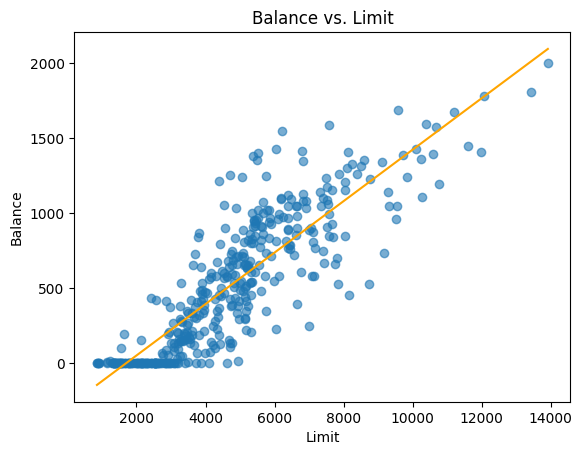

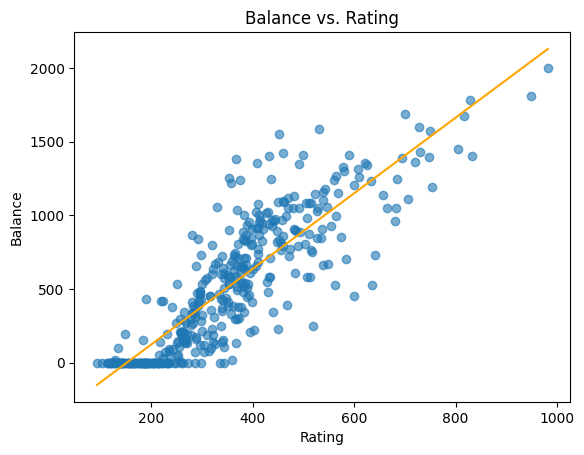

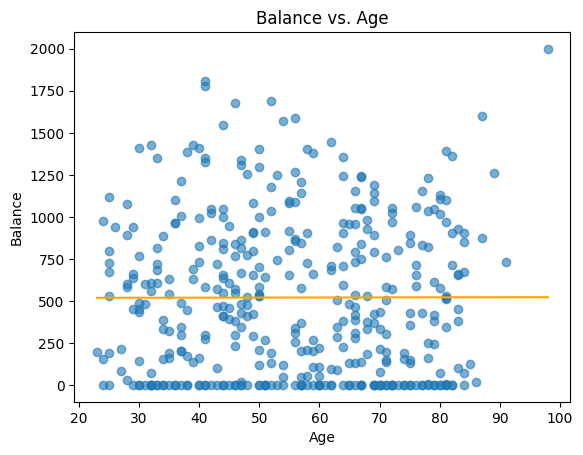

In [3]:
# Select three specific predictors to showcase results
selected_predictors = ["Limit", "Rating", "Age"]

# Create scatterplots of the data and line of best fit obtained above
for predictor in selected_predictors:
    slope = summary_df.loc[summary_df["Predictor"] == predictor, "Slope"].values[0]
    intercept = summary_df.loc[summary_df["Predictor"] == predictor, "Intercept"].values[0]
    
    x = np.linspace(credit[predictor].min(), credit[predictor].max(), 200)
    y = slope * x + intercept
    
    plt.scatter(credit[predictor], credit["Balance"], alpha=0.6)
    plt.plot(x, y, color="orange")
    plt.title(f"Balance vs. {predictor}")
    plt.xlabel(predictor)
    plt.ylabel("Balance")
    plt.show()

**Figure 1:** Scatter plot of `balance` vs `limit` with linear regression line.

**Figure 2:** Scatter plot of `balance` vs `rating` with linear regression line.

**Figure 3:** Scatter plot of `balance` vs `age` with linear regression line.

The table above summarizes the results of fitting simple linear regressions for each predictor.
- `Limit` and `Rating` show strong positive associations with `Balance` ($R^2 > 0.7$, $p < 0.001$).
- `Age` shows almost no relationship with `Balance` ($R^2 \approx 0$, $p \gg 0.05$).
- Other predictors like `Income` and `Education` have weaker but still statistically significant associations. 

The plots (figures 1-3) highlight the contrast: `Limit` and `Rating` have clear, positive linear relationships with `Balance`, while `Age` shows no meaningful pattern.

### Multiple Linear Regression with All Predictors
We now fit a multiple linear regression model to predict `Balance` using all six predictors simultaneously. This allows us to assess the combined explanatory power of the predictors, accounting for correlations among them.
- The **F-statistic** tests the null hypothesis that all slope coefficients are zero (none of the predictors provide explanatory power for `Balance`).
- The **t-statistics** for each coefficient test whether individual predictors have a statistically significant association with the response, after adjusting for the other predictors in the model. In other words, we want to gather evidence for whether we can reject $H_0: \beta_j = 0$.

In [4]:
# Set up DataFrame `X` for predictors and intercept
X = credit[predictors]
X.insert(0, "Intercept", np.ones(credit.shape[0]))

# Set Balance as response variable `y`
y = credit["Balance"]

# Define OLS model using response variable `y` and predictors `X`
model = sm.OLS(y, X)

# Fit the model to the simulated dataset
multi_result = model.fit()

# Store coefficients for comparison with previous model
multi_coefs = multi_result.params[predictors].values.tolist()

# Print summary of the fitted model
multi_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     472.5
Date:                Fri, 29 Aug 2025   Prob (F-statistic):          3.01e-176
Time:                        12:09:49   Log-Likelihood:                -2598.2
No. Observations:                 400   AIC:                             5210.
Df Residuals:                     393   BIC:                             5238.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -477.9581     55.065     -8.680      0.000    -586.217    -369.699
Age           -0.8924      0.478     -1.867      0.063      -1.832       0.048
Cards         11.5916      7.067      1.640      0.102      -2.302      25.485
Education      1.9983      2.600      0.769      0.443      -3.113       7.110
Income        -7.5580      0.382    -19.766      0.000      -8.310      -6.806
Limit          0.1259      0.053      2.373      0.018       0.022       0.230
Rating         2.0631      0.794      2.598      0.010       0.502       3.625
==============================================================================
Omnibus:                       96.489   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.212
Skew:                           1.397   Prob(JB):                     1.09e-37
Kurtosis:                       4.553   Cond. No.                     3.60e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Based on the F statistic ($F = 472.5$) with p-value effectively zero ($p \ll 0.01$), we reject the null hypothesis that none of the predictors are useful. This provides strong evidence that at least one predictor helps explain variation in balance.

To compensate for multiple testing error, we apply the Bonferroni correction when looking at the p-values for the individual predictors. Since we are testing six predictors, the adjusted significance threshold is $\alpha = 0.05 / 6 \approx 0.0083$. We have the following results:
- **Age:** $p = 0.063 > 0.05$, not significant even before correction. We fail to reject $H_0$.
- **Cards:** $p = 0.102 > 0.05$, not significant even before correction. We fail to reject $H_0$.
- **Education:** $p = 0.443 > 0.05$, not significant even before correction. We fail to reject $H_0$.
- **Income:** $p < 0.001$, remains significant even after Bonferroni correction. We reject $H_0$ and conclude that income is a statistically significant predictor.
- **Limit:** $p = 0.018 < 0.05$, but above the Bonferroni-adjusted threshold of $0.0083$. Limit is marginally significant without correction, but not after correction.
- **Rating:** $p = 0.010 < 0.05$, but above the Bonferroni-adjusted threshold of $0.0083$. Rating is marginally significant without correction, but not after correction.

Thus, after accounting for multiple testing, income is the only statistically significant predictor of credit balance in this model.

To compare the results of the univariate and multiple regression models, we plot each predictor’s coefficient estimate from the simple regression (x-axis) against its coefficient estimate from the multiple regression (y-axis).

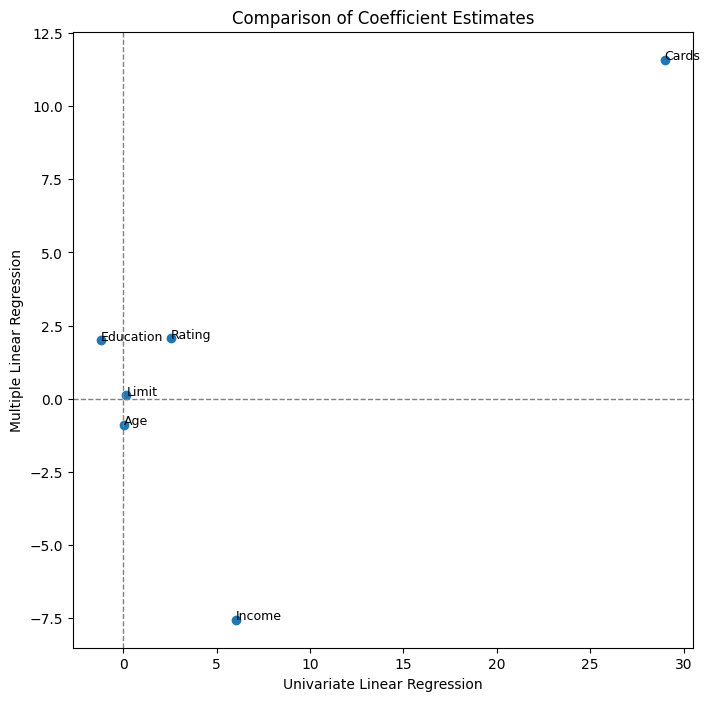

In [5]:
# Scatter plot of univariate vs multiple regression coefficients
plt.figure(figsize=(8,8))
plt.scatter(simple_coefs, multi_coefs)
for i, predictor in enumerate(predictors):
    plt.text(simple_coefs[i], multi_coefs[i], predictor, fontsize=9, ha='left')
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.axvline(0, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Univariate Linear Regression")
plt.ylabel("Multiple Linear Regression")
plt.title("Comparison of Coefficient Estimates")
plt.show()

**Figure 4:** Scatter plot of univariate vs multiple linear regression coefficients.

Comparing the coefficients, we see that most predictors (like income, cards, and rating) have smaller effects in the multiple regression than in the simple regressions. This indicates that the predictors are correlated, so their explanatory power overlaps when considered jointly.

### Exploring Non-Linear Associations
We now investigate whether there is evidence of non-linear relationships between `balance` and the predictors. For each predictor $X$, we fit a cubic polynomial regression model of the form:
$$\text{Balance} = \beta_0 + \beta_1 \cdot \text{Predictor}_i + \beta_2 \cdot \text{Predictor}_i^2 + \beta_3 \cdot \text{Predictor}_i^3 + \epsilon_i$$
We then compare these models to their linear counterparts to see if higher-order terms improve the fit.

In [6]:
# Set up DataFrame `polynomial_results` for predictors and intercept
polynomial_results = pd.DataFrame(columns=["Predictor", "Intercept", "X", "X^2", "X^3",
                                           "p_Intercept", "p_X", "p_X^2", "p_X^3", "R^2"])

for i, predictor in enumerate(predictors):
    x = credit[predictor]
    X_df = pd.DataFrame({
        "Intercept": 1,
        predictor: x,
        predictor + "^2": x**2,
        predictor + "^3": x**3
    })
    y = credit["Balance"]
    model = sm.OLS(y, X_df)
    result = model.fit()
    
    polynomial_results.loc[i] = [
        predictor,
        result.params["Intercept"],
        result.params[predictor],
        result.params[predictor + "^2"],
        result.params[predictor + "^3"],
        result.pvalues["Intercept"],
        result.pvalues[predictor],
        result.pvalues[predictor + "^2"],
        result.pvalues[predictor + "^3"],
        result.rsquared
    ]

polynomial_results

,Predictor,Intercept,X,X^2,X^3,p_Intercept,p_X,p_X^2,p_X^3,R^2
0,Age,-1618.064256,133.047255,-2.556158,1.535822e-02,0.014479,0.000669,0.000431,0.000337,0.032362
1,Cards,667.918563,-189.338977,54.855935,-3.831394e+00,0.000062,0.216400,0.188085,0.252581,0.013253
2,Education,1359.264835,-187.569381,13.192807,-2.952781e-01,0.182278,0.462754,0.520692,0.578752,0.002850
3,Income,294.418582,3.812081,0.019824,-3.533487e-05,0.000589,0.413086,0.763495,0.890382,0.216643
4,Limit,-321.333355,0.160994,0.000007,-5.902999e-10,0.000029,0.000465,0.387158,0.150743,0.749764
5,Rating,-457.931555,2.658348,0.000916,-1.402784e-06,0.000013,0.001217,0.631595,0.292263,0.753616


The DataFrame above shows an increase in $R^2$ for each predictor as a result of expanding the model to include polynomial terms. This makes sense, as the flexibility that comes with polynomial terms allows for better fit, but risks overfitting to the data, a classical example of the bias-variance tradeoff in machine learning.

We can visualize the coefficient and p-value data with a heatmap.

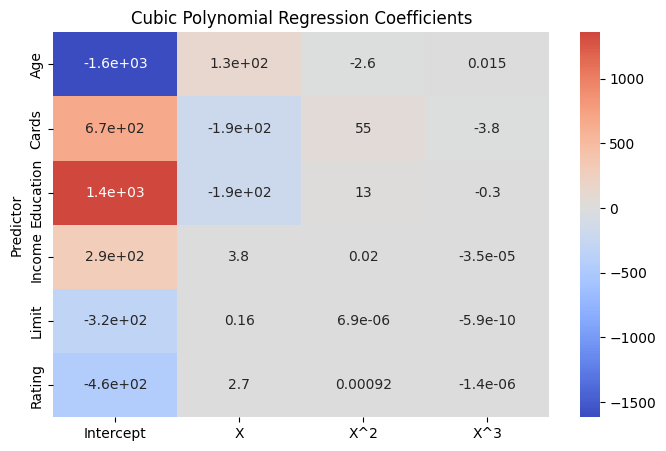

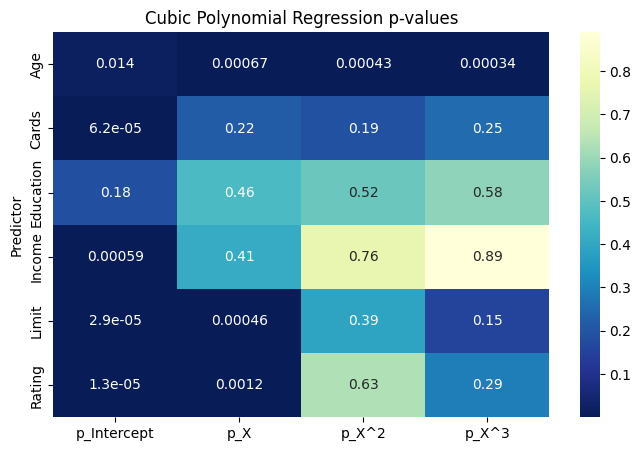

In [7]:
# Select only coefficient columns and set predictor names as index
coef_heatmap = polynomial_results.set_index("Predictor")[["Intercept", "X", "X^2", "X^3"]]
pval_heatmap = polynomial_results.set_index("Predictor")[["p_Intercept", "p_X", "p_X^2", "p_X^3"]]

# Plot heatmap for coefficients
plt.figure(figsize=(8, 5))
sns.heatmap(coef_heatmap, annot=True, cmap="coolwarm", center=0)
plt.title("Cubic Polynomial Regression Coefficients")
plt.show()

# Plot heatmap for p-values
plt.figure(figsize=(8, 5))
sns.heatmap(pval_heatmap, annot=True, cmap="YlGnBu_r")
plt.title("Cubic Polynomial Regression p-values")
plt.show()

**Figure 5:** Heatmap of coefficient values from fitting univariate cubic regression functions.

**Figure 6:** Heatmap of coefficient p-values from fitting univariate cubic regression functions.

We also create a filtered heatmap where only values significant at the $\alpha = 0.05$ level are shown.

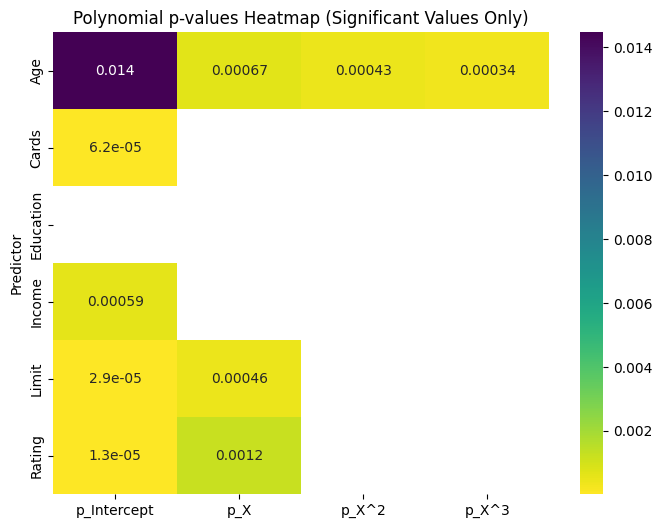

In [8]:
# Create a mask for p-values > 0.05
mask = pval_heatmap > 0.05

plt.figure(figsize=(8, 6))
sns.heatmap(pval_heatmap, annot=True, cmap="viridis_r", mask=mask)
plt.title("Polynomial p-values Heatmap (Significant Values Only)")
plt.show()

**Figure 7:** Heatmap of significant ($\alpha = 0.05$) coefficient p-values from fitting univariate cubic regression functions.

Based on these heatmaps, we can see that the polynomial fit is statistically significant for `Age`, but insignificant for `Education`. We also note that `Income` has near-zero coefficients for each term, an interesting observation. We therefore plot visualizations for these three predictors and overlay their respective regression curves.

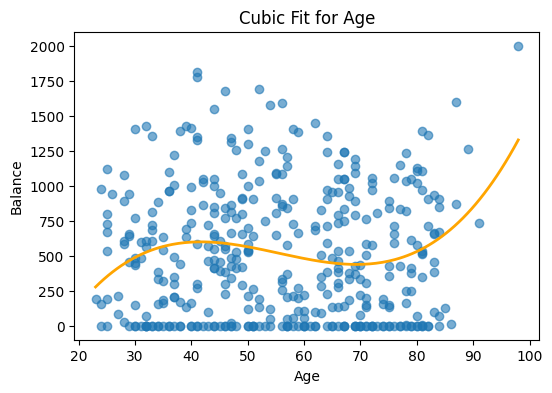

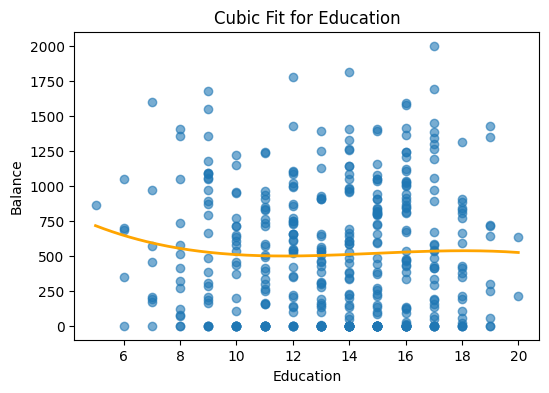

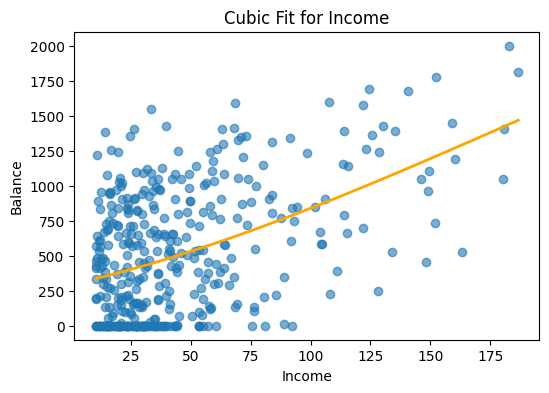

In [9]:
# Choose predictor(s) you want to visualize
selected_predictors = ["Age", "Education", "Income"]

for predictor in selected_predictors:
    x = credit[predictor]
    y = credit["Balance"]

    # Fit cubic polynomial
    cubic_coeffs = np.polyfit(x, y, 3)
    cubic_poly = np.poly1d(cubic_coeffs)

    # Create smooth x-values for plotting
    x_smooth = np.linspace(x.min(), x.max(), 200)
    y_smooth = cubic_poly(x_smooth)

    # Plot scatterplot and cubic curve
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.6)
    plt.plot(x_smooth, y_smooth, color="orange", linewidth=2)
    plt.xlabel(predictor)
    plt.ylabel("Balance")
    plt.title(f"Cubic Fit for {predictor}")
    plt.show()

**Figure 8:** Scatter plot of `balance` vs `age` with cubic regression function.

**Figure 9:** Scatter plot of `balance` vs `education` with cubic regression function.

**Figure 10:** Scatter plot of `balance` vs `income` with cubic regression function.

Figure 8 doesn't obviously show any linear patterns, but the usage of cubic polynomials allows the underlying patterns to be better captured with the predictive equation.

We see similar trends in figure 9, though there are many possible cubic models that could attempt to capture the underlying patterns of the data, hence the lack of statistical significance observed in the p-value heatmap above.

Finally, figure 10 appears mainly linear, hence the near-zero values of the quadratic and cubic term coefficients found in the heatmap.

## Key Takeaways
**Overall:** Income is the primary driver of credit balance, with little evidence that other predictors or non-linear effects substantially improve prediction.
- **Income is the strongest predictor** of credit balance when controlling for other variables. Other predictors lose significance after accounting for multiple testing.
- **Simple vs. multiple regression:** Some predictors appear influential in univariate models but shrink or become non-significant in the multiple regression, highlighting correlations among predictors.
- **Non-linear effects are minimal:** Cubic polynomial models show little evidence of strong non-linear relationships with credit balance.
- **Visualizations clarify patterns:** Scatterplots, regression lines, and heatmaps efficiently summarize effect sizes and statistical significance.